## Group Project: EPA FE Analysis and Prediction

### Context: 


### Objective : 

* To identify the different factors that affect fuel economy in surveyed vehicles
* To make a model to predict if an employee will attrite or not


### Dataset :
The data contains (**replace** - demographic details), (**replace** - work-related metrics) and (**replace** - attrition flag).

* **Manufacturer** - 
* **Model Year** - 
* **Regulatory Class** - 
* **2-Cycle MPG** - 
* **Weight (lbs)** - 
* **Footprint (sq. ft.)** - 
* **Engine Displacement** - 
* **Horsepower (HP)** - 
* **Acceleration (0-60 time in seconds)** - 
* **Drivetrain - 4WD** - 
* **Transmission - Manual** - 
* **Transmission - CVT (Hybrid)** - 
* **Fuel Delivery - Gasoline Direct Injection (GDI)** - 
* **Fuel Delivery - Port Fuel Injection** - 
* **Fuel Delivery - Other** - 
* **Powertrain - Diesel** - 
* **Powertrain - Electric Vehicle (EV)** - 
* **Powertrain - Gasoline** - 
* **Turbocharged Engine** - 
* **Stop/Start** - 
* **Cylinder Deactivation** - 
* **Multivalve Engine** - 
* **Variable Valve Timing** - 
* **Average Number of Gears** - 
* **Transmission - CVT (Non-Hybrid)** - 
* **Transmission - Automatic + Lockup** - 
* **Powertrain - PHEV and Gas Hybrid** - 
* **Drivetrain - Front + Rear** - 


### Import the necessary libraries

In [15]:
# Note: go through later and removed unused dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#to scale the data using z-score 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#algorithms to use
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

#Metrics to evaluate the model
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve

#for tuning the model
from sklearn.model_selection import GridSearchCV

#to ignore warnings
import warnings
warnings.filterwarnings("ignore")

### Read the dataset
Additionally, perform some cleaning and some column combination/drops as agreed upon during prior inspection of the data pool.

In [16]:
#reading the dataset

# use the commented out df definition to import only the columns specified in the above list
df = pd.read_csv('table_export_unclean.csv')

# drop columns decided to be unwanted for our analysis
drops = ['Vehicle Type','Production (000)','Production Share','Real-World MPG','Real-World MPG_City','Real-World MPG_Hwy','Real-World CO2 (g/mi)',
        'Real-World CO2_City (g/mi)','Real-World CO2_Hwy (g/mi)','HP/Weight (lbs)','Ton-MPG (Real-World)','Transmission - Other','Fuel Delivery - Carbureted',
        'Fuel Delivery - Throttle Body Injection','Powertrain - Fuel Cell Vehicle (FCV)','Powertrain - Other (incl. CNG)','HP/Engine Displacement',
        '4 or Fewer Gears','5 Gears','6 Gears','7 Gears','8 Gears','9 or More Gears']

df = df.drop(drops, axis = 1)

# erroneous entries requiring replacement
df = df.replace('-', np.NaN)
df = df.replace('Prelim. 2021', '2021')

# attempt to convert columns from object to numeric type wherever possible - df.infer_objects() wasn't cutting it
cols = df.columns
for col in cols:
    try:
        df[col] = pd.to_numeric(df[col])
    except:
        pass

# drop all data before MY 2005, drop MY 2021
df = df.loc[(df["Model Year"] > 2005) & (df["Model Year"] < 2021)]

# drop all data where the Manufacturer is "All" or "Tesla"
df = df.loc[(df["Manufacturer"] != "All") & (df["Manufacturer"] != "Tesla")]

# combine two transmission columns, two drivetrain columns, and two powertrain columns, dropping the originals
df['Transmission - Automatic + Lockup'] = df['Transmission - Automatic'] + df['Transmission - Lockup']
df['Powertrain - PHEV + Gas Hybrid'] = df['Powertrain - Plug-in Hybrid Electric Vehicle (PHEV)'] + df['Powertrain - Gasoline Hybrid']
df['Drivetrain - Front + Rear'] = df['Drivetrain - Rear'] + df['Drivetrain - Front']
df = df.drop(columns = ['Transmission - Automatic','Transmission - Lockup','Powertrain - Plug-in Hybrid Electric Vehicle (PHEV)',
                        'Powertrain - Gasoline Hybrid','Drivetrain - Rear','Drivetrain - Front'])

df.head()

,Manufacturer,Model Year,Regulatory Class,2-Cycle MPG,Weight (lbs),Footprint (sq. ft.),Engine Displacement,Horsepower (HP),Acceleration (0-60 time in seconds),Drivetrain - 4WD,...,Turbocharged Engine,Stop/Start,Cylinder Deactivation,Multivalve Engine,Variable Valve Timing,Average Number of Gears,Transmission - CVT (Non-Hybrid),Transmission - Automatic + Lockup,Powertrain - PHEV + Gas Hybrid,Drivetrain - Front + Rear
190,GM,2006,Truck,20.70421,4878.158,NaN,286.5538,260.0357,8.8266,0.447,...,NaN,NaN,NaN,0.191,0.191,4.0,NaN,NaN,NaN,NaN
191,GM,2007,Truck,20.33974,5212.624,NaN,297.9739,276.1167,8.8777,0.453,...,NaN,NaN,0.309,0.053,0.114,4.0,NaN,NaN,NaN,NaN
192,GM,2008,Truck,20.87824,5256.952,63.19281,298.1435,276.7135,9.0098,0.506,...,NaN,NaN,0.498,0.053,0.147,4.0,NaN,NaN,NaN,NaN
193,GM,2009,Truck,20.80280,5325.399,64.27464,304.7528,290.5567,8.4069,0.509,...,NaN,NaN,0.646,0.088,0.099,4.7,NaN,NaN,NaN,NaN
194,GM,2010,Truck,21.47343,5317.757,63.67333,303.2716,287.6503,8.3991,0.605,...,NaN,NaN,0.602,0.101,0.923,5.3,NaN,NaN,NaN,NaN


### Dataset Info

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1440 entries, 190 to 5155
Data columns (total 28 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Manufacturer                                     1440 non-null   object 
 1   Model Year                                       1440 non-null   int64  
 2   Regulatory Class                                 1440 non-null   object 
 3   2-Cycle MPG                                      1338 non-null   float64
 4   Weight (lbs)                                     1338 non-null   float64
 5   Footprint (sq. ft.)                              1160 non-null   float64
 6   Engine Displacement                              1338 non-null   float64
 7   Horsepower (HP)                                  1338 non-null   float64
 8   Acceleration (0-60 time in seconds)              1338 non-null   float64
 9   Drivetrain - 4WD            

## Exploratory Data Analysis and Data Preprocessing

In [18]:
# What should we do about manufacturer = "All"?
df.Manufacturer.unique()

array(['GM', 'Honda', 'BMW', 'Ford', 'Hyundai', 'Stellantis', 'Mazda',
       'Toyota', 'VW', 'Nissan', 'Subaru', 'Kia', 'Mercedes'],
      dtype=object)

### Check summary statistics

In [19]:
df.describe()

,Model Year,2-Cycle MPG,Weight (lbs),Footprint (sq. ft.),Engine Displacement,Horsepower (HP),Acceleration (0-60 time in seconds),Drivetrain - 4WD,Transmission - Manual,Transmission - CVT (Hybrid),...,Turbocharged Engine,Stop/Start,Cylinder Deactivation,Multivalve Engine,Variable Valve Timing,Average Number of Gears,Transmission - CVT (Non-Hybrid),Transmission - Automatic + Lockup,Powertrain - PHEV + Gas Hybrid,Drivetrain - Front + Rear
count,1440.000000,1338.000000,1338.000000,1160.000000,1338.000000,1338.000000,1338.000000,1090.000000,888.000000,307.000000,...,834.000000,390.000000,368.000000,1315.000000,1300.000000,1328.000000,409.000000,259.000000,164.000000,655.000000
mean,2013.000000,29.660773,4108.410531,49.387625,180.338577,228.137829,8.471030,0.473750,0.053400,0.042704,...,0.289408,0.395151,0.270603,0.932608,0.889299,5.705271,0.397643,0.915703,0.065146,0.723061
std,4.321995,5.516004,606.513653,5.229635,45.340371,47.873106,0.857965,0.341892,0.063667,0.054316,...,0.329625,0.356515,0.288137,0.178908,0.232271,1.408672,0.363087,0.120818,0.058798,0.264735
min,2006.000000,15.410690,2997.372000,42.561640,94.121100,131.000000,5.837100,0.005000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.024000,0.001000,1.000000,0.001000,0.228000,0.000000,0.109000
25%,2009.000000,25.597803,3626.926500,45.885303,144.439175,187.246875,7.928400,0.149250,0.012000,0.005000,...,0.033000,0.052250,0.043750,0.988000,0.946750,5.000000,0.034000,0.884000,0.023000,0.523500
50%,2013.000000,28.984040,4000.000000,47.442685,169.303500,221.345200,8.520600,0.448000,0.033000,0.020000,...,0.112500,0.282000,0.139000,1.000000,1.000000,5.900000,0.296000,0.956000,0.047000,0.785000
75%,2017.000000,33.648922,4507.627000,51.425970,212.000000,265.039825,8.993750,0.776500,0.065250,0.062500,...,0.490000,0.737500,0.450750,1.000000,1.000000,6.300000,0.768000,0.990000,0.085000,0.963000
max,2020.000000,45.547250,6668.898000,68.433210,366.142200,379.280300,11.797900,1.000000,0.474000,0.266000,...,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,1.000000,1.000000,0.275000,1.000000


### Attempt correlation analysis

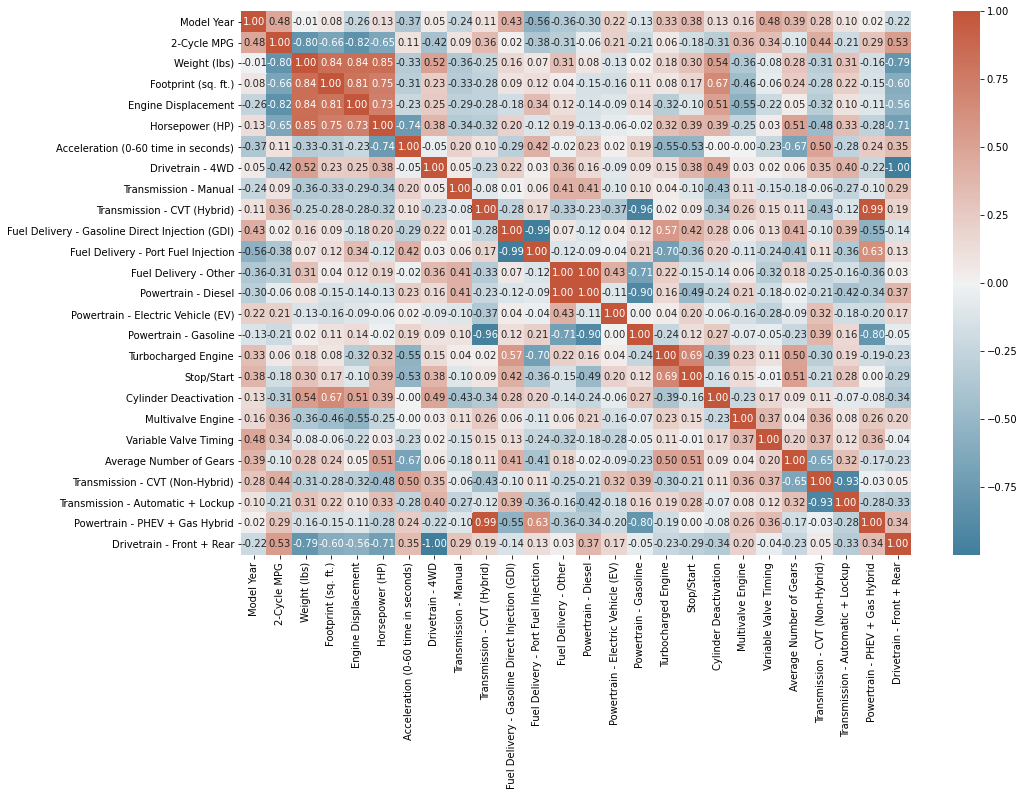

In [20]:
plt.figure(figsize=(15,10))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(df.corr(),annot=True,fmt='.2f',cmap=cmap )
plt.show()